In [4]:
# === Basis-Imports ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Machine Learning / Deep Learning ===
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import (
    MobileNetV2, ResNet50V2, EfficientNetB0
)

# === Tools ===
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

100%|██████████| 658M/658M [10:36<00:00, 1.08MB/s] 

Extracting files...


Path to dataset files: C:\Users\thien\.cache\kagglehub\datasets\emmarex\plantdisease\versions\1


Datensatzordner: C:\Users\thien\.cache\kagglehub\datasets\emmarex\plantdisease\versions\1\PlantVillage\PlantVillage
Anzahl Klassen: 15
Klassen-Beispiele: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold']

Bilder pro Klasse:
Pepper__bell___Bacterial_spot: 997
Pepper__bell___healthy: 1478
Potato___Early_blight: 1000
Potato___healthy: 152
Potato___Late_blight: 1000
Tomato_Bacterial_spot: 2127
Tomato_Early_blight: 1000
Tomato_healthy: 1591
Tomato_Late_blight: 1909
Tomato_Leaf_Mold: 952
Tomato_Septoria_leaf_spot: 1771
Tomato_Spider_mites_Two_spotted_spider_mite: 1676
Tomato__Target_Spot: 1404
Tomato__Tomato_mosaic_virus: 373
Tomato__Tomato_YellowLeaf__Curl_Virus: 3208


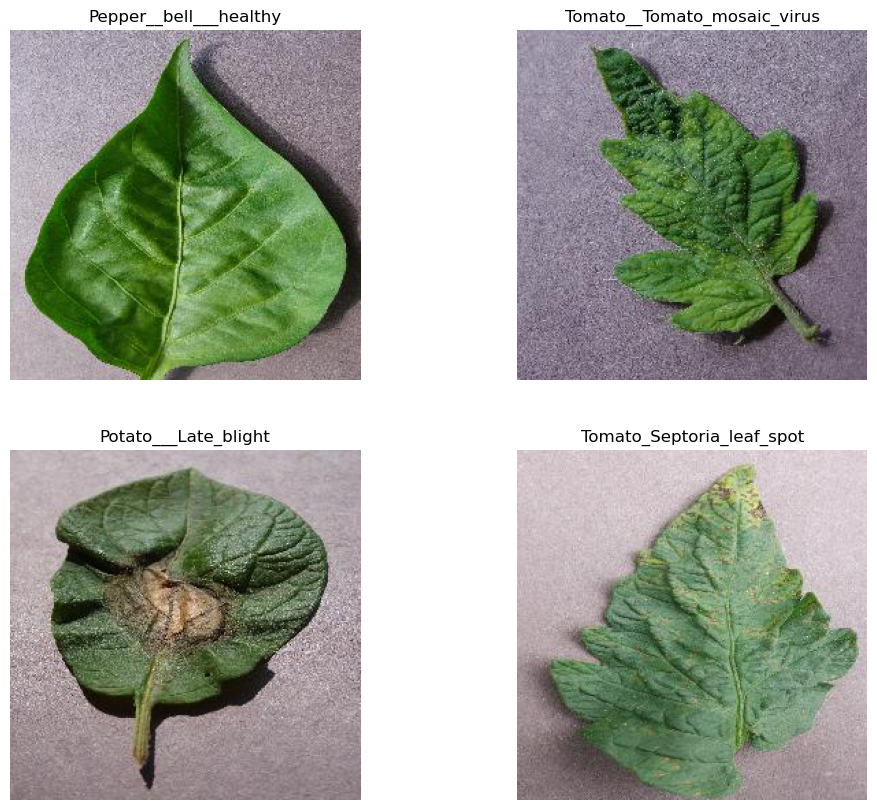

In [12]:
import random
from PIL import Image

# Richtiger PlantVillage-Datenordner
dataset_dir = os.path.join(path, "PlantVillage", "PlantVillage")

print("Datensatzordner:", dataset_dir)

# --- Klassenordner ---
folders = [
    f for f in os.listdir(dataset_dir)
    if os.path.isdir(os.path.join(dataset_dir, f))
]

print("Anzahl Klassen:", len(folders))
print("Klassen-Beispiele:", folders[:10])

# --- Bilder pro Klasse zählen ---
class_counts = {}
for cls in folders:
    cls_path = os.path.join(dataset_dir, cls)
    images = [
        f for f in os.listdir(cls_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]
    class_counts[cls] = len(images)

print("\nBilder pro Klasse:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

# --- Beispielbilder anzeigen ---
sample_classes = random.sample(folders, 4)

plt.figure(figsize=(12, 10))
for i, cls in enumerate(sample_classes):
    cls_folder = os.path.join(dataset_dir, cls)
    images = [f for f in os.listdir(cls_folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    img_name = random.choice(images)
    img_path = os.path.join(cls_folder, img_name)

    img = Image.open(img_path)

    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.show()
